In [230]:
# torch에서 제공하는 신경망, 손실함수, 최적화 함수 불러오기
import torch
from torch import nn
from torch import optim

# 데이터 정리용 라이브러리
from torch.utils.data import DataLoader, Dataset

# 데이터 호출
from sklearn.datasets import load_boston

# 표준화 모듈 호출
from sklearn.preprocessing import StandardScaler

In [231]:
# 데이터 호출
bos = load_boston()

/home/helpme/.conda/envs/text/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California ho

In [232]:
# data X,Y 분할
X = bos['data'] # (506, 13)
Y = bos['target'].reshape([-1,1]) # (506, 1)

In [233]:
# train, test 분할
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# train, test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# validation set 분할
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [235]:
# 데이터 스케일링
scaler = StandardScaler() # 클래스 호출

### 표준화 방법 1
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test) # fit_transform 사용 X

In [236]:
# dataset 구축
# torch.utils.data.Dataset 을 상속받음

class HousingData(Dataset):
    # 데이터셋의 전처리를 해주는 부분
    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    # 데이터셋의 길이, 총 샘플 수를 출력
    def __len__(self):
        return self.len

    # 데이터셋에서 특정 1개의 샘플을 꺼내오기
    # dataset[i]를 하면 i번째 샘플을 가져오도록 하는 인덱싱을 처리
    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [237]:
#### train data, test data로 나누어 구축

# trainsets 
trainsets = HousingData(X_train, y_train)
# shuffle True로 데이터셋 학습 순서를 바꿔줌, 데이터 batch 처리 
train_loader = torch.utils.data.DataLoader(trainsets, batch_size=10, shuffle=True)

# validation sets
validationsets = HousingData(X_val, y_val)
val_loader = torch.utils.data.DataLoader(validationsets, batch_size=10, shuffle=True)

# testsets
testsets = HousingData(X_test, y_test)
test_loader = torch.utils.data.DataLoader(testsets, batch_size=10, shuffle=False)

### 모델 구축

In [238]:
# 모델 정의
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__() # nn.Module 상속받기
        
        self.relu = nn.ReLU()                  # ReLU 활성화층

        self.fc1 = nn.Linear(13, 64, bias=True) # 입력층(13) -> 은닉층1(64)
        self.fc2 = nn.Linear(64, 64, bias=True) # 은닉충1(64) -> 은닉층2(64)
        self.fc3 = nn.Linear(64, 1, bias=True)  # 은닉충2(64) -> 출력층(1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

In [239]:
model = NeuralNetwork()

from torchinfo import summary
summary(model,(323,13))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [323, 1]                  --
├─Linear: 1-1                            [323, 64]                 896
├─ReLU: 1-2                              [323, 64]                 --
├─Linear: 1-3                            [323, 64]                 4,160
├─ReLU: 1-4                              [323, 64]                 --
├─Linear: 1-5                            [323, 1]                  65
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
Total mult-adds (M): 1.65
Input size (MB): 0.02
Forward/backward pass size (MB): 0.33
Params size (MB): 0.02
Estimated Total Size (MB): 0.37

In [244]:
# 옵티마이저, 손실함수 정의
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
criterion = nn.MSELoss()
Epochs = 80

# 디바이스 설정
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

# 모델 디바이스 설치

model.to(device)

Using cpu device


In [243]:
## 학습 진행하기
loss_ = [] # loss 저장용 빈 리스트 만들기
val_loss_ = []

n = len(train_loader)
m = len(val_loader)

for epoch in range(Epochs):

    running_loss = 0.0
    
    for i, data in enumerate(train_loader):
        
        inputs, values = data # data X, y 받기

        outputs = model(inputs) # 모델 학습

        loss = criterion(outputs, values) # cost 계산

        optimizer.zero_grad() # 매 학습마다 가중치 0으로 초기화

        loss.backward() # 손실 함수를 기준으로 역전파 설정

        optimizer.step() # 역전파 진행 후 가중치 업데이트

        running_loss += loss.item() # epoch 마다 평균 loss 를 계산하기 위해 배치 loss 를 더함

    loss_.append(running_loss/n) # MSE 계산

    with torch.no_grad():
        val_loss = 0.0
        for j, test_data in enumerate(val_loader):

            val_inputs, val_values = test_data

            test_outputs = model(val_inputs)

            test_loss = criterion(test_outputs, val_values)

            val_loss += test_loss.item()

        val_loss_.append(val_loss/m)



    print(f'Epoch {epoch+1:4d}/{Epochs} Batch {i+1}/{len(train_loader)} Cost: {loss.item():.6f}, val_Batch {j+1}/{len(val_loader)} val_cost: {test_loss.item():.6f}')
    

Epoch    1/80 Batch 33/33 Cost: 853.078796, val_Batch 9/9 val_cost: 26.808449
Epoch    2/80 Batch 33/33 Cost: 386.622162, val_Batch 9/9 val_cost: 1501.059937
Epoch    3/80 Batch 33/33 Cost: 436.368683, val_Batch 9/9 val_cost: 29.299765
Epoch    4/80 Batch 33/33 Cost: 41.016518, val_Batch 9/9 val_cost: 25.482191
Epoch    5/80 Batch 33/33 Cost: 27.606295, val_Batch 9/9 val_cost: 9.766894
Epoch    6/80 Batch 33/33 Cost: 22.799765, val_Batch 9/9 val_cost: 28.697678
Epoch    7/80 Batch 33/33 Cost: 16.436529, val_Batch 9/9 val_cost: 3.643314
Epoch    8/80 Batch 33/33 Cost: 18.758356, val_Batch 9/9 val_cost: 88.248238
Epoch    9/80 Batch 33/33 Cost: 11.721604, val_Batch 9/9 val_cost: 5.767224
Epoch   10/80 Batch 33/33 Cost: 4.980506, val_Batch 9/9 val_cost: 5.968169
Epoch   11/80 Batch 33/33 Cost: 6.439968, val_Batch 9/9 val_cost: 24.479929
Epoch   12/80 Batch 33/33 Cost: 22.625986, val_Batch 9/9 val_cost: 9.265742
Epoch   13/80 Batch 33/33 Cost: 14.047863, val_Batch 9/9 val_cost: 16.273405
E

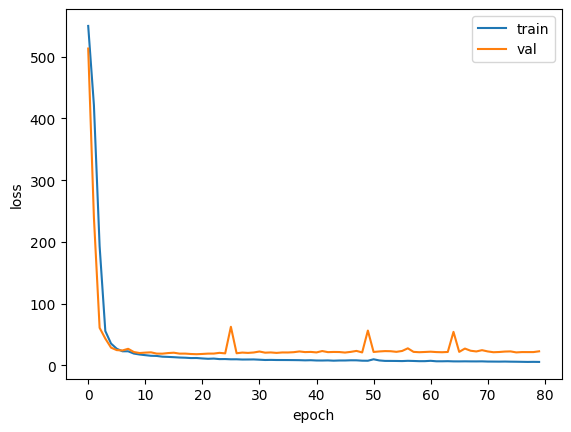

In [211]:
import matplotlib.pyplot as plt

plt.plot(loss_)
plt.plot(val_loss_)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [254]:

def evaluation(dataloader):
    
    predictions = torch.tensor([], dtype=torch.float) #예측값 저장을 위한 빈 텐서 
    actual = torch.tensor([], dtype=torch.float) #실제값 저장을 위한 빈 텐서 
    with torch.no_grad(): #requires_grad 비활성화 
        model.eval() #dropout과 같은 모델 학습시에만 사용하는 기법들을 비활성화 
        
        #배치 단위로 데이터를 예측하고 예측값과 실제값을 누적해서 저장 
        for data in dataloader:
            inputs, values = data
            outputs = model(inputs)
            
            #0차원으로 누적한다는 의미
            predictions = torch.cat((predictions, outputs), 0)  
            actual = torch.cat((actual, values), 0)
    
    predictions = predictions.numpy()
    actual = actual.numpy()
    rmse = np.sqrt(mean_squared_error(predictions, actual))
    
    return rmse

In [260]:
train_rmse = evaluation(train_loader)
test_rmse = evaluation(test_loader)
 
print('학습용 셋 : ', train_rmse)
print('테스트 셋 : ', test_rmse)

print(f'accuracy : {train_rmse / test_rmse}')

학습용 셋 :  2.527515
테스트 셋 :  2.9715989
accuracy : 0.850557267665863
